In [31]:
# 한글깨짐
import platform
import matplotlib.pyplot as plt

os = platform.system()

# Windows
if os == 'Windows':
    plt.rc('font', family= 'Malgun Gothic')

else:
    print(f'{os} is not set')

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
rc('font', family = 'Malgun Gothic')
rc('axes', unicode_minus = False)

import pandas as pd
from konlpy.tag import Mecab
from emoji import core
from gensim import corpora, models
from collections import Counter
import re
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
mecab = Mecab(dicpath=r"C:/mecab/mecab-ko-dic")

file_path ='best_real_last_reviews_with_group_help_ox.csv'
df = pd.read_csv(file_path)
df['help_cnt_yes']=df['help_cnt'].apply(lambda x:0 if x == 0 else 1)
df=df[(df['help_cnt_yes']==0) & (df['predicted_class']==1)] # 도움 0 & 긍정
df['review']=df['review'].str.replace(" +", " ")


def load_stopwords(filepath):
    with open(filepath, 'r', encoding='cp949') as file:
        stopwords = file.read().strip().split(',')
        return set(stopwords)
    
def clean_text(text):
  text= core.replace_emoji(text,replace='')
  text=re.sub(r'[^가-힣0-9\.]',' ',text) # 알파벳, 숫자, 마침
  text=re.sub(r'\.+','.',text) # 연속된 마침표
  text=re.sub(r'\n',' ',text) # 줄바꿈 문자
  text=re.sub(r'^[.]|[.]$',' ',text)

  return text.strip()

def remove_stopwords(text, stopwords):
    words = text.split()  # 텍스트를 공백 기준으로 분할
    filtered_words = [word for word in words if word not in stopwords]  # 불용어 제거
    return ' '.join(filtered_words)
    
stopwords = load_stopwords('../data/stopwords.txt')

df['review']=df['review'].apply(clean_text)

df['review']=df['review'].apply(lambda x : remove_stopwords(x,stopwords))

In [34]:
tokenized_docs = [mecab.pos(review) for review in df['review']]
tokenized_docs = [[word[0] for word in doc 
                   if word[0] not in stopwords and len(word[0]) > 1 and (word[0] not in ['생각','구매','신발','유면','원대', '대부분', '애용','해용', '산거','신한','신음','다운','일가','만한','이만', '애신','이용','응기','행력','은지','경우','해유','나용','니더', '구여','이면','여요','애요','아이오']) 
                   and (word[1] in ('NNG','VA','XR','SL')) ] for doc in tokenized_docs]

token_counts = Counter(word for doc in tokenized_docs for word in doc)
token_df = pd.DataFrame(token_counts.items(), columns=['Morpheme', 'Frequency'])

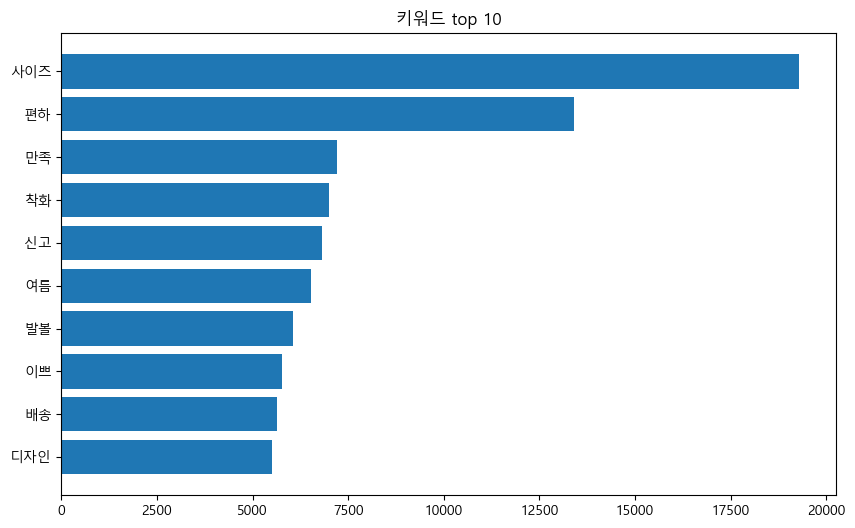

In [35]:
sort_token=token_df.sort_values(by='Frequency',ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(sort_token['Morpheme'],sort_token['Frequency'])
plt.title('키워드 top 10')
plt.gca().invert_yaxis() #y축 반전
plt.show()#

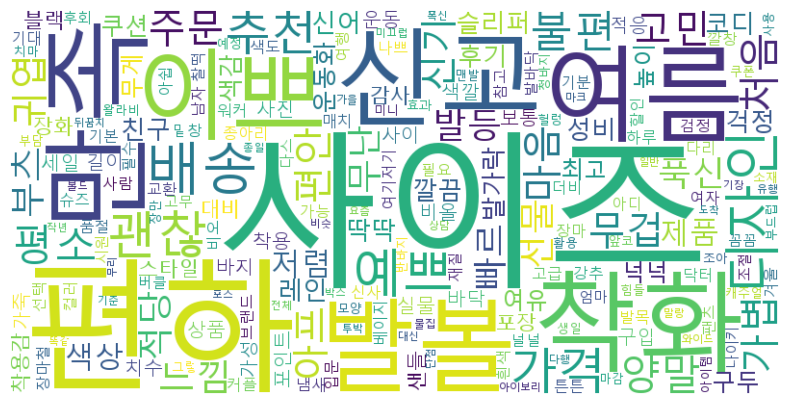

In [36]:
font_path='C:/Windows/Fonts/malgun.ttf'
# 워드클라우드 객체 생성
wordcloud = WordCloud(font_path=font_path, width = 800, height = 400, background_color ='white').generate_from_frequencies(token_counts)

# 워드클라우드 보여주기
plt.figure(figsize=(10, 5))  # 크기 조정
plt.imshow(wordcloud, interpolation="bilinear")  # 이미지 표시
plt.axis("off")  # 축 제거
plt.show()

In [37]:
id2word = corpora.Dictionary(tokenized_docs)
corpus = [id2word.doc2bow(doc) for doc in tokenized_docs]
columns_as_lists = tokenized_docs

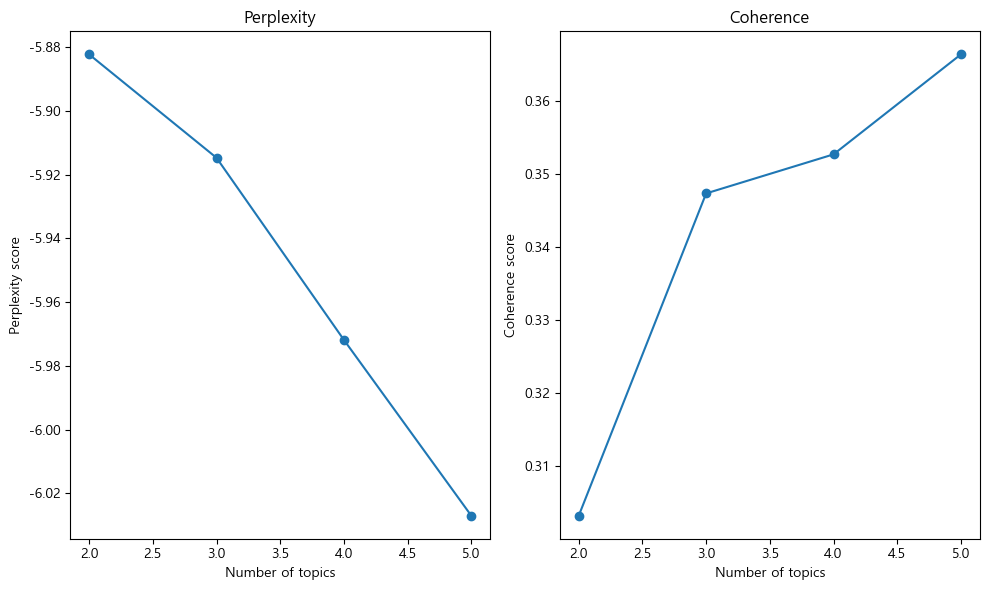

In [38]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt


start_topic = 2
end_topic = 5
step = 1
topic_range = range(start_topic, end_topic + 1, step)

# Perplexity 계산
perplexity_values = []
for i in topic_range:
    
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=id2word)
    perplexity_values.append(ldamodel.log_perplexity(corpus)) 

# Coherence 계산
coherence_scores = []
for i in topic_range:
    lda_model = LdaModel(corpus, num_topics=i, id2word=id2word, passes=15)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=columns_as_lists, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_score)


fig, axes = plt.subplots(1, 2, figsize=(10, 6))
x = topic_range
plt.rcParams['axes.unicode_minus'] = False

# Perplexity subplot
axes[0].plot(x, perplexity_values, marker='o')
axes[0].set_xlabel('Number of topics')
axes[0].set_ylabel('Perplexity score') 
axes[0].set_title('Perplexity') 


# Coherence subplot
axes[1].plot(topic_range, coherence_scores, marker='o')
axes[1].set_xlabel('Number of topics')
axes[1].set_ylabel('Coherence score')
axes[1].set_title('Coherence')


plt.tight_layout()
plt.show()

In [48]:
optimal_co = topic_range[coherence_scores.index(max(coherence_scores))]
print("최적토픽 수 : ", optimal_co)

최적토픽 수 :  5


In [49]:
lda_model = models.LdaModel(corpus, # 말뭉치
                            num_topics=5, # 최적의 주제수
                            id2word=id2word, # 단어사전
                            #chunksize=20, # 각 학습 단계에서 사용하는 문서의 수
                            #passes=15, # 말뭉치 반복 횟수
                            #iterations=100, # 각 문서에 대해 LDA 모델 반복 횟수
                            per_word_topics=True) # 각 단어에 대한 토픽 정보 저장

In [50]:
for topic_id, topic_words in lda_model.print_topics():
    print(f"Topic {topic_id}: {topic_words}") # 키워드 가중치, 키워드

Topic 0: 0.159*"편하" + 0.059*"여름" + 0.039*"신기" + 0.036*"슬리퍼" + 0.033*"귀엽" + 0.030*"가볍" + 0.028*"마음" + 0.024*"예쁘" + 0.021*"디자인" + 0.019*"최고"
Topic 1: 0.068*"이쁘" + 0.067*"신고" + 0.062*"편안" + 0.041*"착화" + 0.037*"디자인" + 0.035*"양말" + 0.027*"딱딱" + 0.026*"느낌" + 0.017*"슈즈" + 0.016*"신어"
Topic 2: 0.049*"처음" + 0.048*"불편" + 0.041*"부츠" + 0.040*"아프" + 0.035*"무난" + 0.029*"무겁" + 0.029*"레인" + 0.026*"괜찮" + 0.024*"편하" + 0.023*"신고"
Topic 3: 0.106*"만족" + 0.087*"배송" + 0.066*"가격" + 0.043*"선물" + 0.038*"빠르" + 0.031*"저렴" + 0.030*"친구" + 0.023*"색감" + 0.022*"이쁘" + 0.022*"제품"
Topic 4: 0.189*"사이즈" + 0.064*"발볼" + 0.035*"평소" + 0.030*"편하" + 0.026*"주문" + 0.026*"알파" + 0.026*"발등" + 0.025*"적당" + 0.025*"바운스" + 0.021*"추천"


In [51]:
# dominant topic and its percentage contribution in each document

def topic_sentences(ldamodel=None, corpus=None, texts=None, df=None):
    topic_list = []

    # 문서별 토픽 할당
    for n in range(len(corpus)):
        doc_topic = ldamodel.get_document_topics(corpus[n], minimum_probability=0.0)
        doc_topic = sorted(doc_topic, key=lambda x: x[1], reverse=True)
        topic_most_pr = doc_topic[0][0]
        topic_pr = doc_topic[0][1]
        
        # 키워드 추출
        wp = ldamodel.show_topic(topic_most_pr)
        topic_keywords = ", ".join([word for word, prop in wp])
        
        topic_list.append([n, topic_most_pr, topic_pr, topic_keywords])
    
  
    topic_df = pd.DataFrame(topic_list, columns=['document_num', 'Dominant_Topic', 'Percentage', 'Keywords'])
    topic_df = topic_df.set_index('document_num')
    
    
    df = df.reset_index(drop=True)
    result_df = topic_df.join(df[['review']], how='inner')

    # 옵션 설정: 최대 컬럼 너비
    pd.set_option('display.max_colwidth', 1000)

    return result_df.reset_index(drop=True)


topic_df = topic_sentences(ldamodel=lda_model, corpus=corpus, texts=df['review'], df=df)

topic_df.head()

,Dominant_Topic,Percentage,Keywords,review
0,1,0.754328,"이쁘, 신고, 편안, 착화, 디자인, 양말, 딱딱, 느낌, 슈즈, 신어",샌들 사려고 했는데 디자인이 특이해 보여서 샀어요 맨발로 신어봤는데 발등에 물집잡혀서 한동안 힘드니까 꼭 양말 신고 신발 신는거 추천 드려용
1,1,0.564193,"이쁘, 신고, 편안, 착화, 디자인, 양말, 딱딱, 느낌, 슈즈, 신어",다행히 소량 재고가 있어서 배송은 빨리 왔고 260 정사이즈로 주문했는데 편안하고 좋아요 여기에 와이드 팬츠 입어도 이쁠 같아요
2,1,0.797198,"이쁘, 신고, 편안, 착화, 디자인, 양말, 딱딱, 느낌, 슈즈, 신어",가볍고 부드럽습니다 끈이 고무줄 되어있어서 편해요
3,3,0.733310,"만족, 배송, 가격, 선물, 빠르, 저렴, 친구, 색감, 이쁘, 제품",아주 싼티가 나는거 같지만 가격대비 좋아요
4,3,0.799976,"만족, 배송, 가격, 선물, 빠르, 저렴, 친구, 색감, 이쁘, 제품",여친이랑 커플신발 했는데 여친이 좋아해요


In [52]:
# topic 별 가장 대표하는 review
representative_sen=topic_df.groupby('Dominant_Topic')['Percentage'].idxmax()

topic_df.loc[representative_sen]

,Dominant_Topic,Percentage,Keywords,review
529,0,0.918024,"편하, 여름, 신기, 슬리퍼, 귀엽, 가볍, 마음, 예쁘, 디자인, 최고",아디케인은 첫 구매인데 색상이 크림색깔로 예뻐요 여름에 시원해 보이고 굿 굽도 높지 않고 적당해 편하다고 하네요 여름 쪼리로 강추
28218,1,0.919632,"이쁘, 신고, 편안, 착화, 디자인, 양말, 딱딱, 느낌, 슈즈, 신어",아주 귀엽고 예쁜 메리제인이에요 겨울에도 두꺼운 양말 신고 신으려고 일부러 크게 구매했는데 맨발에도 얇은 양말 신고 신어도 편안해요
72569,2,0.926695,"처음, 불편, 부츠, 아프, 무난, 무겁, 레인, 괜찮, 편하, 신고",이거 자주 신고 싶어서 비오는 날을 기다렸었어요. 종아리 근육이 발달하고 짧아 콤플렉스인데 부츠가 콤플렉스가 보완되는 느낌이 강했던 레인 부츠에요
58350,3,0.938453,"만족, 배송, 가격, 선물, 빠르, 저렴, 친구, 색감, 이쁘, 제품",가격대비만족가격대비만족해요 가격대비만족가격대비만족해요
64365,4,0.957392,"사이즈, 발볼, 평소, 편하, 주문, 알파, 발등, 적당, 바운스, 추천",한사이즈 아래도 괜찮다고 하는데 발볼이 좁은거 아니라 정사이즈로 주문했는데 좋아요 발등이 높은편인지 아래로 했음 잠글때 힘들었을거 같아요 발볼좁고 발등낮은분들은 아래로 해도 될거 같아요 전 적당하게 편하게 맞았어요 폭신하고 편해서 데일리로 신을거 같아요 키도 커보이고 넘 좋네요 편할거 같아 주문한건데 꽤 스타일리시해서 원피스에도 어울릴거 같아요 편하게 잘 신을게요 화이트도 구매하고 싶어 고민중이요


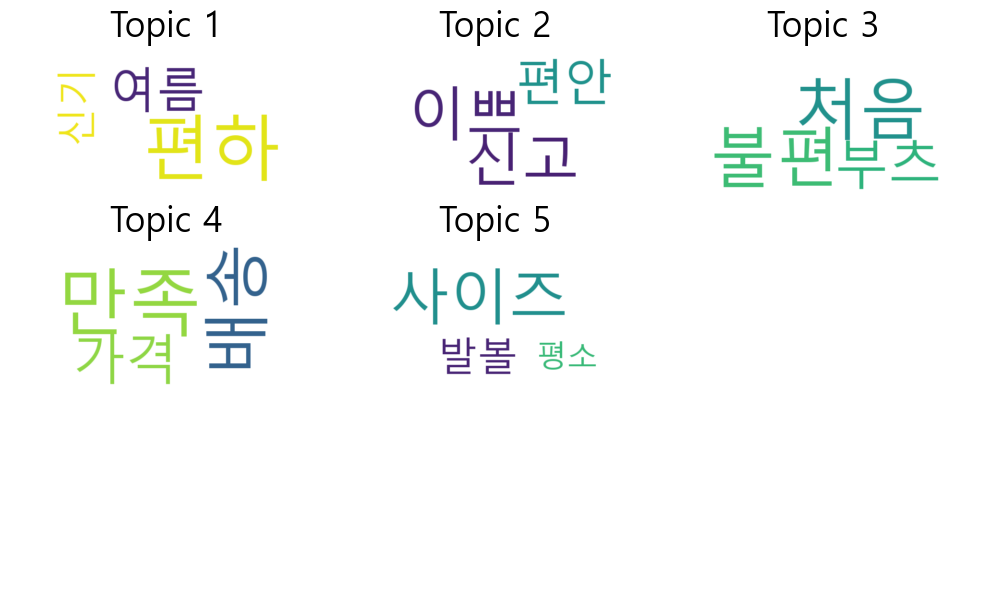

In [53]:
topic_df = topic_sentences(ldamodel=lda_model, corpus=corpus, texts=df['review'], df=df)

# 토픽별 워드 클라우드 생성( 가중치 시각화)
fig, axes = plt.subplots(3, 3, figsize=(10, 6), sharex=True, sharey=True)
wordcloud = WordCloud(font_path=font_path,width=500, height=300, background_color='white')

for i, ax in enumerate(axes.flatten()):
    if i >= len(lda_model.get_topics()): 
        ax.axis('off')
        continue

    fig.add_subplot(ax)
    topic_words = dict(lda_model.show_topic(i, topn=3))  # 각 토픽의 상위 3개 키워드 사용
    wordcloud.generate_from_frequencies(topic_words)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('Topic ' + str(i+1), fontdict=dict(size=25))
    ax.axis('off')

plt.tight_layout()
plt.show()

C:\Users\jk032\AppData\Local\Temp\ipykernel_17676\3904257.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis', ax=ax)


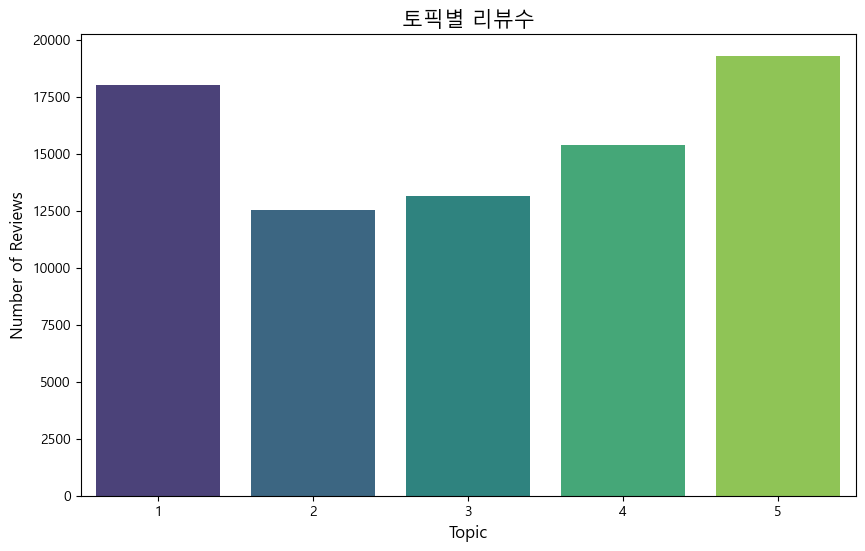

In [54]:
topic_df = topic_sentences(ldamodel=lda_model, corpus=corpus, texts=df['review'], df=df)

# 토픽별 리뷰 수
topic_counts = topic_df['Dominant_Topic'].value_counts().sort_index()

# 막대 차트 시각화
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis', ax=ax)
ax.set_title('토픽별 리뷰수', fontsize=15)
ax.set_xlabel('Topic', fontsize=12)
ax.set_ylabel('Number of Reviews', fontsize=12)

ax.set_xticks(range(len(topic_counts)))
ax.set_xticklabels(range(1, len(topic_counts) + 1))

plt.xticks(rotation=0)
plt.show()

In [55]:
#pyLDA
vis = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis,local=False)

In [56]:
pyLDAvis.save_html(vis, 'lda_visualization_help0pos.html')
# file:///C:/Users/jk032/zerobase/mlproject/lda_visualization_help0pos.html#topic=0&lambda=1&term=